# Simulator

This notebook goes over the basic usage of the simulator class interface to running some basic simulations of a Smoluchowski eqution, and shows how you can extend the functionality to work for a new system by defining a force function.

After going through this notebook you should understan how to perform the following taasks using this package:
- Initialize an instance of the FPE simulator class by defining a configuration dictionary
- Run a simulation of the model system for a fixed amount of time in a static environment
- Run a simulation of the model system in a dynamic environment
- Calculate physical quantities, like work input, for the model system
- Define a new, custom model, and use the simulator interface to run the model

In [1]:
# Import necessary requirements
import numpy as np
from fokker_planck.simulator.simulator import HarmonicEquilibrationSimulator
from fokker_planck.types.basetypes import BoundaryCondition

%load_ext autoreload
%autoreload 2

# Define the required configuration for the system, we will look at a domain of
# -2 -> +2 with a discretization of 0.01 in space and 0.001 in time
config = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.00025,
    "x_min": -2.0,
    "x_max": 2.0,
    "boundary_cond": BoundaryCondition.HardWall
}

# An alternate, but equivalent configuration would specify, instead of x_min
# and x_max, the range of x values directly:
config_alt = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.00025,
    "x_array": np.arange(-2, 2, 0.01),
    "boundary_cond": BoundaryCondition.HardWall
}


In [5]:
# Now we can initialize the simulator class with the configuration as well
# as a few parameters that are intended to be used for dynamic potentials

harmonic_sim = HarmonicEquilibrationSimulator(config, k_trap=8.0)
# harmonic_sim.initialize_probability(init_var = 1/16)
harmonic_sim.initialize_probability(mean=-0.25, init_var=1/32)

# And then run the simulation
sim_result = harmonic_sim.run_simulation(tau=0.5)

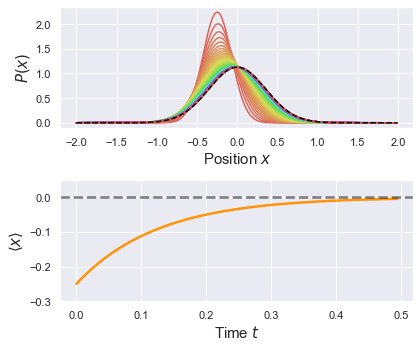

In [28]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
plot_dir = Path().resolve().parents[1] / 'figures' / 'reports'
sns.set(style='darkgrid', palette='hls')

fig, ax = plt.subplots(2, 1, figsize=(6, 5))

Pal = sns.color_palette('hls', len(sim_result.prob_tracker[::20]))

mean_tracker = []
norm_tracker = []

for i, prob in enumerate(sim_result.prob_tracker[::20]):
    ax[0].plot(sim_result._sim.fpe.x_array, prob, color=Pal[i], linewidth=1.5)
    _mean = np.sum(sim_result._sim.fpe.x_array * prob) * sim_result._sim.fpe.dx
    mean_tracker.append(_mean)
    norm_tracker.append(np.sum(prob) * sim_result._sim.fpe.dx)

time_range = np.arange(0, 0.5, config['dt'])
eq_dist = np.exp(-0.5 * 8.0 * (sim_result._sim.fpe.x_array) ** 2)
eq_dist = eq_dist / np.sum(eq_dist * sim_result._sim.fpe.dx)

ax[1].plot(sim_result.time[::20], mean_tracker, color=sns.xkcd_rgb['tangerine'], linewidth=2.5)
ax[1].set_ylim([-0.3, 0.05])
ax[1].axhline(0, linestyle='--', linewidth=2.5, color='k', alpha=0.5)
ax[0].plot(sim_result._sim.fpe.x_array, eq_dist, color='k', linestyle='--')

ax[0].set_xlabel(r'Position $x$', fontsize=15)
ax[0].set_ylabel(r'$P(x)$', fontsize=15)
ax[1].set_xlabel(r'Time $t$', fontsize=15)
ax[1].set_ylabel(r"$\langle x\rangle$", fontsize=15)
plt.tight_layout()
plt.savefig(plot_dir / 'relaxation_harmonic_sim_ex.pdf')
plt.savefig(plot_dir / 'relaxation_harmonic_sim_ex.png', dpi=600)
plt.show()


In [26]:
from fokker_planck.integrator import FokkerPlank1D
import fokker_planck.forceFunctions as ff

x_array = np.arange(-3, 3, 0.01)
fpe = FokkerPlank1D(1.0, 0.00025, 0.01, x_array)
fpe.initialize_probability(0, 0.25)
prob_tracker = []

for _ in range(100):
    prob_tracker.append(fpe.prob.copy())
    fpe.integrate_step(([4.0, 0]), ff.harmonic_force)